In [45]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.optimize import curve_fit
from scipy.stats import chi2
from scipy.stats import norm
import scipy.constants as scp
import scipy.integrate as integrate
from tabulate import tabulate
from scipy import signal
import scipy.constants as const

In [46]:
def sigma(x, y, dx, dy, label):
    s = np.abs(x-y)/np.sqrt(dx**2 + dy**2)
    print('Sigmaabweichung {} ='.format(str(label)), s)
    return s

---

# Frequenzgang

In [47]:
f, Ua, _ = np.loadtxt('./a3-frequenzgang.txt', skiprows=1, unpack=True)

In [48]:
D = 1e-3
dD = 0.02*D
Ue = 0.2

g = Ua/(Ue * D)

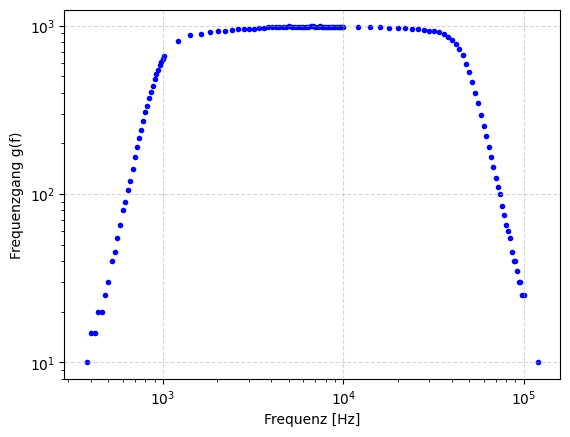

In [49]:
plt.grid(alpha=0.5, linestyle='--')
plt.scatter(f[14:-43], g[14:-43], marker='.', color='blue')
#plt.axis([4e2, 1.5e5, 10, 1.5E3])
plt.xlabel('Frequenz [Hz]')
plt.ylabel('Frequenzgang g(f)')
plt.xscale('log')
plt.yscale('log')

## Fitfunktion

In [50]:
def fit_func(f,V,W1,W2,n1,n2):
    return V/(np.sqrt(1+1/(f/W1)**(2*n1))*np.sqrt(1+(f/W2)**(2*n2)))

In [51]:
#Eistellungen:
V = 1000
W1 = 1000
W2 = 50000
n1 = 5
n1 = 5

p0=[1000 , 1000 , 50000 , 5 , 5]

In [52]:
popt, pcov = curve_fit(fit_func, f[14:-43], g[14:-43], p0)
print(popt)

[9.68211734e+02 1.03290379e+03 4.51390026e+04 4.37714687e+00
 4.51815935e+00]


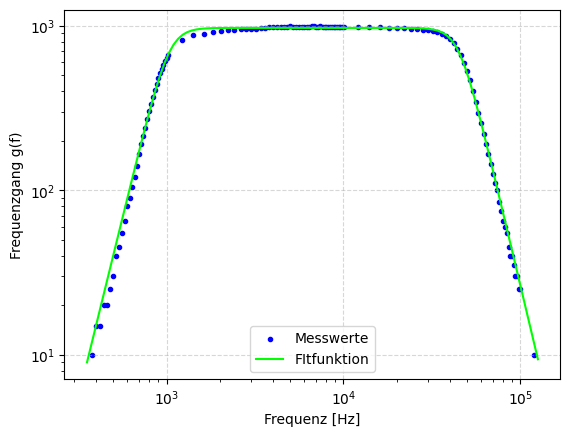

In [53]:
X = np.logspace(2.55, 5.1, 100)

plt.grid(alpha=0.5, linestyle='--')
plt.scatter(f[14:138], g[14:138], marker='.', color='blue', label='Messwerte')
plt.plot(X, fit_func(X, *popt), color='lime', label='FItfunktion')
#plt.axis([4e2, 1.5e5, 10, 1.5E3])
plt.xlabel('Frequenz [Hz]')
plt.ylabel('Frequenzgang g(f)')
plt.legend(loc='lower center')
plt.xscale('log')
plt.yscale('log')
plt.savefig('./plots/Frequenzgang.pdf', format='PDF')

In [54]:
print("V = ({} +/- {})".format(popt[0], np.sqrt(pcov[0][0])))
print("Omega1 = ({} +/- {})Hz".format(popt[1], np.sqrt(pcov[1][1])))
print("Omega2 = ({} +/- {})Hz".format(popt[2], np.sqrt(pcov[2][2])))
print("n1 = ({} +/- {})".format(popt[3], np.sqrt(pcov[3][3])))
print("n2 = ({} +/- {})".format(popt[4], np.sqrt(pcov[4][4])))

V = (968.2117338196566 +/- 2.232223502263777)
Omega1 = (1032.9037914265557 +/- 4.712554932786904)Hz
Omega2 = (45139.00263417587 +/- 194.26882885458375)Hz
n1 = (4.37714687480718 +/- 0.09350208477333055)
n2 = (4.518159346131695 +/- 0.08495693174210123)


## Numerische Integration

In [55]:
def fit_func_square(f,V,W1,W2,n1,n2):
    return fit_func(f,V,W1,W2,n1,n2)**2

In [56]:
B = integrate.quad(fit_func_square, f[14], f[138], args=tuple(popt))

print('Das Integral beträgt: {value:.4e}'.format(value=B[0]))

Das Integral beträgt: 4.2189e+10


# Boltzmann Konstante

In [57]:
#Messung:
R = np.array([5,10,15,20,25,30]) * 1e3 #ohm
Ur = np.array([2.3126,2.9865,3.5322,4.0079,4.4425,4.8354]) #mV
dUr = np.array([0.0009,0.0011,0.0013,0.0015,0.0017,0.0020]) #mV
Uv = 1.3225 #mV
dUv = 0.0005 #mV
T = 273.15 + 22.8 #K
dT = 0.3

dR = 0.005 * R
dUr = np.sqrt((0.003*Ur)**2 + dUr**2)

In [58]:
D = Ur**2 - Uv**2
dD = np.sqrt((2*Ur*dUr)**2 + (2*Uv*dUv)**2)

In [59]:
def linfit(x,a):
    return a*x

In [60]:
l_pop, l_cov = curve_fit(linfit, R, D, sigma=dD, absolute_sigma=True)

c = l_pop[0] * (1e-3)**2 #V/ohm
dc = np.sqrt(l_cov[0][0]) * (1e-3)**2

print("alpha = ({} +/- {})".format(c, dc))

alpha = (7.180121470684113e-10 +/- 2.0902333806897085e-12)


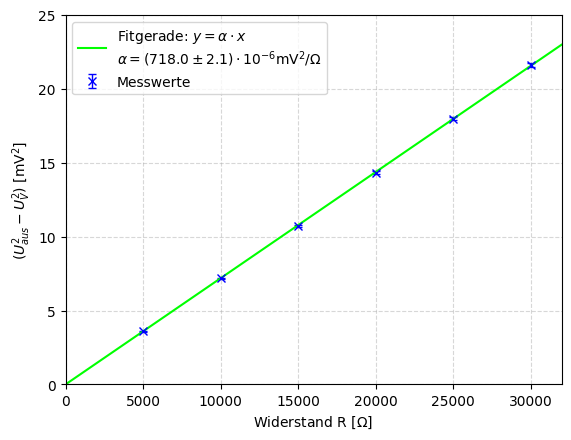

In [61]:
X = np.linspace(0,32e3, 100)

plt.grid(alpha=0.5, linestyle='--')
plt.errorbar(R, D, yerr=dD, fmt='x', color='blue', label='Messwerte', capsize=3, lw=1)
plt.plot(X, linfit(X, *l_pop), color='lime', 
        label="\n".join([r"Fitgerade: $y = \alpha \cdot x$", 
                          r'$\alpha = ({:.1f} \pm {:.2}) \cdot 10^{}$mV$^2 / \Omega$'.format(l_pop[0]*1e6, np.sqrt(l_cov[0][0])*1e6, '{-6}')]))
plt.legend()
plt.xlabel(r'Widerstand R [$\Omega$]')
plt.ylabel(r'$(U_{aus}^2 - U_V^2)$ [mV$^2$]')
plt.axis([0,3.2e4,0,25])
plt.savefig('./plots/Steigungsdings.pdf', format='PDF')

In [62]:
chisquare = np.sum(((linfit(R,*l_pop)-D)**2/dD**2))
dof = 5 #degrees of freedom
chisquare_red = chisquare/dof
print(chisquare_red)

0.234082946822467


In [63]:
prob = round(1-chi2.cdf(chisquare,dof),2)*100
print("Wahrscheinlichkeit="+str(prob)+"%")

Wahrscheinlichkeit=95.0%


In [64]:
#boltzmann:
k = c/(4*T*B[0])
dk_stat = k * np.sqrt((dc/c)**2 + (dT/T)**2)
dk_sys = k * np.sqrt(0.02**2)

print(r'Boltzmann-Konstante k = ({:.3f} +/- {:.1} +/- {:.1}) {}'.format(k*1e23, dk_stat*1e23, dk_sys*1e23, '10^{-23} J/K'))

Boltzmann-Konstante k = (1.438 +/- 0.004 +/- 0.03) 10^{-23} J/K


In [65]:
#sigmaabweichung:
k_lit = 1.380649e-23 # NIST CODATA value

_ = sigma(k, k_lit, np.sqrt(dk_stat**2 + dk_sys**2), 0, 'Boltzmann')

Sigmaabweichung Boltzmann = 1.9588937493553469
